## Purpose and brief description: 
This project uses Ted Talks Data set from Kaggle.com which contains data(details and Transcripts) for 2550 ted talks held by the company upto september 2017

This project is divided into 3 parts.
1. Data Analysis and Visualizations : This aims to provide answer and visualization to questions like 
        i)What are most popular ted talks?
        ii)How are views and comments on ted talks distributed? Is there any correation between them?
        iii)What kind of ted talks attract the maximum discussion and debate (in the form of comments and views)?
        iv)Which months are most popular among TED and TEDx chapters?
        v)Finding out which ted talks have best ratings?
   
    Data Analyis is done using pyspark and visualtions uses pandas,matplotlib and seaborn 
        
        
2. Text based Content Recommender : This aims to provide content recommendation of ted talks based only on the text transcripts of the ted talks, this is helpful to provide recommendation for new users whose recommendations maybe cannot be made due to no past user activity



3. Prediction model to predict if a ted talk will be popular or not. The popularity of the TED talk will be defined by the type of Ratings whether the show had positive feedback or negative feedback. The aim is to build a classifier on the basis of the tags associated with the ted talk and occupation of speaker to predict whether the talk will be popular or not.

# What did I learn?
I was able to learn a lot about Data Anaysis and Machine Learning from this project. I came across a great number of  important and new concepts for applying data exploration and visualizations to our Ted data. The data is really awesome to work on as it consists of all the statistical data types like numerical, ordinal and categorical values. 

Using pyspark for data analysis was a new adventure as I was using it for the first time, analyzing ted data with pyspark I got to learn how to manipulate dataframes in pyspark, how to wirte apply like functions in pyspark i.e udf(user defined function) and wirte required queries in spark sql. Initially I thought using pandas would be much easier and straight forward for data analysis due to its extensive library and our existing knowlege of pandas but I was successfully able to do all the required analysis using pyspark even though it does not look as pretty, it gets all the work done very effectively. The only negative of pyspark was not having a visualization library to work with spark dataframe due to which I had to convert all spark dataframes into pandas after each analysis so I could use matplotlib and seaborn for visualization. 


The second data file i.e. Transcripts.csv taught us a whole new way of working with the text data, a good time where I learned a type of Machine learning other than computer vision i.e. Natural Language Processing. I came to know about the feature engineering present in text data, the way I can count the words in the paragraphs and use the counts of words as a feature to find some useful recommendations. By playing with this data I was learning about how to design and build any Recommendation system along with anticipating how the real world powerful recoomendation systems might have been working. 

I also learned a lot about the way of  applying the machine learning models on our ted talks data for predicting the popularity of the show. I learned why data cleaning is important before you apply any model on the data and importance of going through every feature present in the data and determing whether it will have major or minor impact for your predictions. 

While practicing the models on our input data I learned a way to compare all the models by applying vaiours sklearn classification metrices to choose the best model. I decided to keep Random Forest Classifier as a final classifer for our data and tried to learn more about the changes in the output when I was analysing different values for the parameters of the model. 

Overall, I learnt a lot of interesting concepts present in Data exporation and Machine learning by engaging ourselves into the data and having a good time with the ted data.

# Special Instructions that I need to run the project. 

The Jupyter Notebook needs to have a active spark session, this can be tested by running sc command (cell 2 of this notebook)

# Third party libraries list them and give the pip command needed to install them.

I have used only standard libraries for this project which include pyspark,pandas,sklearn,seaborn,matplotlib and numpy

In [1]:
#importing all the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import calendar
import ast
import datetime
import re
from time import time
import zipfile


import pyspark.sql.functions as F
from pyspark import SparkContext
from pyspark.sql.functions import col, column
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import col,split,explode, unix_timestamp, to_date, month, UserDefinedFunction,date_format,udf,array,from_unixtime,dayofweek,year
from pandas.plotting import parallel_coordinates


from sklearn.feature_extraction import text
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, fbeta_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer,classification_report,accuracy_score,f1_score,precision_score,recall_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
import joblib
from joblib import dump, load

%matplotlib inline

In [2]:
#checking active spark session if this command produces an error please reopen jupyter notebook in a spark session 
sc

<SparkContext master=local[*] appName=PySparkShell>

In [3]:
#defining sql context
sqlCtx = SQLContext(sc)

## The TedTalks Data Set
There are two CSV files.

ted_main.csv - Contains data on actual TED Talk metadata and TED Talk speakers.

transcripts.csv - Contains transcript and URL information for TED Talks

In [4]:
#File paths
# Link to download the data set : https://www.kaggle.com/rounakbanik/ted-talks/download
# Google Drive Link : https://drive.google.com/uc?id=19YqIehG5BJB0gYmAZ9I9QbIQgUfnlHOA&export=download
ted_zip_path='C:/SDSU/BDA/Project/ted-talks.zip'
ted_talks_zip = zipfile.ZipFile(ted_zip_path) 
#loading data set in pandas
ted_talks_pandas = pd.read_csv(ted_talks_zip.open('ted_main.csv'))
ted_scripts_pandas = pd.read_csv(ted_talks_zip.open('transcripts.csv'))

In [5]:
#convert pandas dataframe into spark dataframe 
tedSchema = StructType([ StructField("comments", LongType(), True)\
                       ,StructField("description", StringType(), True)\
                       ,StructField("duration", LongType(), True)\
                       ,StructField("event", StringType(), True)\
                       ,StructField("film_date", LongType(), True)\
                       ,StructField("languages", IntegerType(), True)\
                       ,StructField("main_speaker", StringType(), True)\
                       ,StructField("name", StringType(), True)\
                       ,StructField("num_speaker", IntegerType(), True)\
                       ,StructField("published_date", LongType(), True)\
                       ,StructField("ratings", StringType(), True)\
                       ,StructField("related_talks", StringType(), True)\
                       ,StructField("speaker_occupation", StringType(), True)\
                       ,StructField("tags", StringType(), True)\
                       ,StructField("title", StringType(), True)\
                       ,StructField("url", StringType(), True)\
                       ,StructField("views", LongType(), True)])

pyspark_ted_talks = sqlCtx.createDataFrame(ted_talks_pandas[['comments', 'description', 'duration', 'event', 'film_date',
       'languages', 'main_speaker', 'name', 'num_speaker', 'published_date',
       'ratings', 'related_talks', 'speaker_occupation', 'tags', 'title',
       'url', 'views']],schema=tedSchema)
pyspark_ted_talks

DataFrame[comments: bigint, description: string, duration: bigint, event: string, film_date: bigint, languages: int, main_speaker: string, name: string, num_speaker: int, published_date: bigint, ratings: string, related_talks: string, speaker_occupation: string, tags: string, title: string, url: string, views: bigint]

### Features Available
name: The official name of the TED Talk. Includes the title and the speaker.

title: The title of the talk

description: A blurb of what the talk is about.

main_speaker: The first named speaker of the talk.

speaker_occupation: The occupation of the main speaker.

num_speaker: The number of speakers in the talk.

duration: The duration of the talk in seconds.

event: The TED/TEDx event where the talk took place.

film_date: The Unix timestamp of the filming.

published_date: The Unix timestamp for the publication of the talk on TED.com

comments: The number of first level comments made on the talk.

tags: The themes associated with the talk.

languages: The number of languages in which the talk is available.

ratings: A stringified dictionary of the various ratings given to the talk (inspiring, fascinating, jaw dropping, etc.)

related_talks: A list of dictionaries of recommended talks to watch next.

url: The URL of the talk.

views: The number of views on the talk.

In [6]:
##converting the Unix timestamps into a human readable format
pyspark_ted_talks = pyspark_ted_talks.withColumn('film_date_converted', from_unixtime(pyspark_ted_talks.film_date,format="yyyy-MM-dd")) 
pyspark_ted_talks = pyspark_ted_talks.withColumn('published_date_converted', from_unixtime(pyspark_ted_talks.published_date,format="yyyy-MM-dd"))
pyspark_ted_talks = pyspark_ted_talks.drop('published_date','film_date')
pyspark_ted_talks = pyspark_ted_talks.withColumnRenamed('film_date_converted','film_date')
pyspark_ted_talks = pyspark_ted_talks.withColumnRenamed('published_date_converted','published_date')
pyspark_ted_talks.select('name','title','film_date','published_date').show(10)

+--------------------+--------------------+----------+--------------+
|                name|               title| film_date|published_date|
+--------------------+--------------------+----------+--------------+
|Ken Robinson: Do ...|Do schools kill c...|2006-02-24|    2006-06-26|
|Al Gore: Averting...|Averting the clim...|2006-02-24|    2006-06-26|
|David Pogue: Simp...|    Simplicity sells|2006-02-23|    2006-06-26|
|Majora Carter: Gr...| Greening the ghetto|2006-02-25|    2006-06-26|
|Hans Rosling: The...|The best stats yo...|2006-02-21|    2006-06-27|
|Tony Robbins: Why...|Why we do what we do|2006-02-01|    2006-06-27|
|Julia Sweeney: Le...|   Letting go of God|2006-02-23|    2006-07-09|
|Joshua Prince-Ram...|Behind the design...|2006-02-22|    2006-07-09|
|Dan Dennett: Let'...|Let's teach relig...|2006-02-01|    2006-07-17|
|Rick Warren: A li...|   A life of purpose|2006-02-24|    2006-07-17|
+--------------------+--------------------+----------+--------------+
only showing top 10 

In [7]:
pyspark_ted_talks.count()

2550

I have over 2550 talks at our disposal. These represent all the talks that have ever been posted on the TED Platform until September 21, 2017 and has talks filmed in the period between 1994 and 2017. It has been over two decades of TED.

### Most Viewed Talks of All Time

In [8]:
popular_ted_talks = pyspark_ted_talks.select('title', 'main_speaker', 'views', 'film_date').orderBy('views', ascending = False).limit(25)
popular_ted_talks = popular_ted_talks.withColumn('abbr', popular_ted_talks.main_speaker[0:3])
popular_ted_talks.show(25)

+--------------------+--------------------+--------+----------+----+
|               title|        main_speaker|   views| film_date|abbr|
+--------------------+--------------------+--------+----------+----+
|Do schools kill c...|        Ken Robinson|47227110|2006-02-24| Ken|
|Your body languag...|           Amy Cuddy|43155405|2012-06-25| Amy|
|How great leaders...|         Simon Sinek|34309432|2009-09-16| Sim|
|The power of vuln...|         Brené Brown|31168150|2010-06-05| Bre|
|10 things you did...|          Mary Roach|22270883|2009-02-05| Mar|
|How to speak so t...|     Julian Treasure|21594632|2013-06-09| Jul|
|My stroke of insight|   Jill Bolte Taylor|21190883|2008-02-26| Jil|
|Why we do what we do|        Tony Robbins|20685401|2006-02-01| Ton|
|This is what happ...|        James Veitch|20475972|2015-12-07| Jam|
|Looks aren't ever...|     Cameron Russell|19787465|2012-10-26| Cam|
|The puzzle of mot...|            Dan Pink|18830983|2009-07-23| Dan|
|The power of intr...|          Su

 Bar chart to visualise these 25 talks in terms of the number of views they garnered.

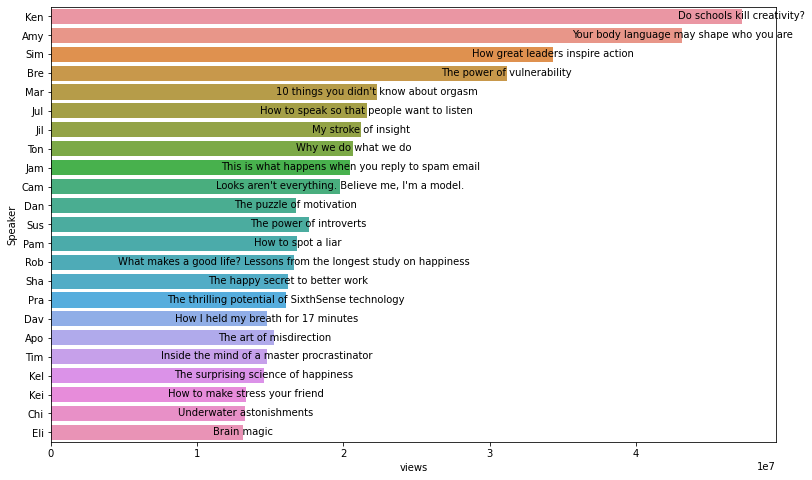

In [9]:
pop_talks = popular_ted_talks.toPandas()
lis = list(pop_talks.title)
plt.figure(figsize=(13, 8))
splot = sns.barplot(data=pop_talks, x = 'views', y = 'abbr', ci = None)
plt.ylabel('Speaker')
count = 0
for p in splot.patches:
    splot.annotate(lis[count],(p.get_x()+p.get_width(),p.get_y()+0.9),ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    count+=1

Observations : 
1. Ken robinson's talk 'Do schools kill creativity' has the highest views of all ted talks with over 47.2 million views
2. There are two talks that have over 40 million views and 4 talks which have passed 30 million views in the data set

Let us see statistics and the distibution of the views garnered on various TED Talks.

In [10]:
pyspark_ted_talks.describe('views').show()

+-------+------------------+
|summary|             views|
+-------+------------------+
|  count|              2550|
|   mean|1698297.4815686275|
| stddev|2498479.3721852046|
|    min|             50443|
|    max|          47227110|
+-------+------------------+



We can see that a ted talk gets about 1.6 million views on average which is a very high number and the least viewing that a ted talk has is 50k

### Ted Talks Comments

In [11]:
pyspark_ted_talks.describe('comments').show()

+-------+------------------+
|summary|          comments|
+-------+------------------+
|  count|              2550|
|   mean|191.56235294117647|
| stddev|282.31522325728355|
|    min|                 2|
|    max|              6404|
+-------+------------------+



We can see that a ted talk gets about 191 comments on average which is a very low number as compared to number of views suggesting very few people are commenting after watching the ted talk. 
Let us see the correlation between views and comments

In [12]:
print("Correaltion between views and comments: "+ str(pyspark_ted_talks.stat.corr("views", "comments")))

Correaltion between views and comments: 0.5309387006213679


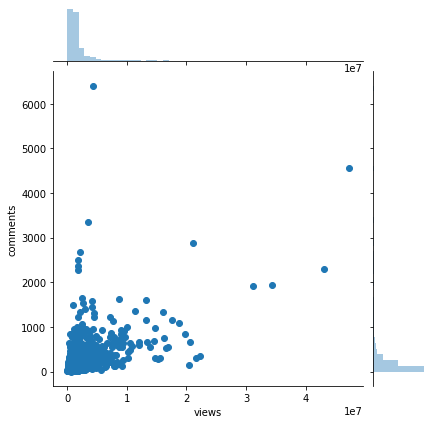

In [13]:
sns.jointplot(x='views', y='comments', data=ted_talks_pandas)

As the scatterplot shows and the pearson coefficient is slightly more than 0.5. This suggests a medium to strong correlation between the views and  comments.

### Number of views and comments on the 25 most commented TED Talks of all time

In [14]:
top_comments = pyspark_ted_talks.select('title', 'main_speaker','views', 'comments').orderBy('comments', ascending = False).limit(25)
top_comments.show(25)

+--------------------+--------------------+--------+--------+
|               title|        main_speaker|   views|comments|
+--------------------+--------------------+--------+--------+
|    Militant atheism|     Richard Dawkins| 4374792|    6404|
|Do schools kill c...|        Ken Robinson|47227110|    4553|
|Science can answe...|          Sam Harris| 3433437|    3356|
|My stroke of insight|   Jill Bolte Taylor|21190883|    2877|
|How do you explai...|      David Chalmers| 2162764|    2673|
|Taking imaginatio...|      Janet Echelman| 1832930|    2492|
|On reading the Koran|     Lesley Hazleton| 1847256|    2374|
|Your body languag...|           Amy Cuddy|43155405|    2290|
|The danger of sci...|     Michael Specter| 1838628|    2272|
|How great leaders...|         Simon Sinek|34309432|    1930|
|The power of vuln...|         Brené Brown|31168150|    1927|
|A tale of two pol...|          Eric X. Li| 2449736|    1640|
|How to live befor...|          Steve Jobs| 8744428|    1627|
|Your el

Richard Dawkins' talk on Militant Atheism' generated the greatest amount of discussion and opinions despite having significantly lesser views than Ken Robinson's talk, which is second in the list. 
Also comparing the list to top 25 viwed and top 25 commented talks we see that only 7 of the top 25 viewed talks made in the list of top commented talksThis raises some interesting questions.

Which talks tend to attract the largest amount of discussion?

To answer this question, we will define a new feature discussion quotient which is simply the ratio of the number of comments to the number of views. We will then check which talks have the largest discussion quotient.

In [15]:
pyspark_ted_talks = pyspark_ted_talks.withColumn('dis_quo', pyspark_ted_talks.comments/pyspark_ted_talks.views)
top_discussion = pyspark_ted_talks.select('title', 'main_speaker','views', 'comments','dis_quo').orderBy('dis_quo', ascending = False).limit(25)
top_discussion.show(25)

+--------------------+--------------------+-------+--------+--------------------+
|               title|        main_speaker|  views|comments|             dis_quo|
+--------------------+--------------------+-------+--------+--------------------+
|The case for same...|     Diane J. Savino| 292395|     649|0.002219600198361...|
|E-voting without ...|       David Bismark| 543551|     834|0.001534354641974718|
|    Militant atheism|     Richard Dawkins|4374792|    6404|0.001463841023756...|
|Inside a school f...|Sharmeen Obaid-Ch...|1057238|    1502|0.001420682949345...|
|Taking imaginatio...|      Janet Echelman|1832930|    2492|0.001359571833076004|
|On reading the Koran|     Lesley Hazleton|1847256|    2374|0.001285149432455...|
|Curating humanity...|   Elizabeth Lindsey| 439180|     555|0.001263718748576...|
|How do you explai...|      David Chalmers|2162764|    2673| 0.00123591848209051|
|The danger of sci...|     Michael Specter|1838628|    2272|0.001235704014080064|
|Dance to change

The most discussed talk is 'The case for same Sex Marriage' which has 649 comments on only 292k views.
There seems to be 2 reccuring themes for highly discussed ted talks
1. Most of top discussed talks have either based on religious beliefs like 'On reading Koran', 'Superheros of Islam' or challenging them with likes of 'The case for same sex marriage and 'Militant Atheism' nonethe less a lot of talks in the list have an underlying theme of faith which seems to create debate among people in the comments
2. The other underlying theme in talks seems to be of Science and challenging it 

### Analysing TED Talks by the month and the year

In [16]:
monthName = udf(lambda z: toMonthName(z), StringType())
spark.udf.register("monthName", monthName)

def toMonthName(monthNo):
    return calendar.month_name[monthNo][0:3]

pyspark_ted_talks = pyspark_ted_talks.withColumn('flim_month_no', month(pyspark_ted_talks.film_date))
pyspark_ted_talks = pyspark_ted_talks.withColumn('flim_month',monthName('flim_month_no'))
month_ted_talks = pyspark_ted_talks.groupBy('flim_month').count().orderBy('count', ascending = False)
month_ted_talks.show()

+----------+-----+
|flim_month|count|
+----------+-----+
|       Feb|  645|
|       Mar|  354|
|       Jun|  271|
|       Jul|  250|
|       Nov|  240|
|       Oct|  205|
|       Apr|  172|
|       May|  123|
|       Sep|  114|
|       Dec|  111|
|       Jan|   33|
|       Aug|   32|
+----------+-----+



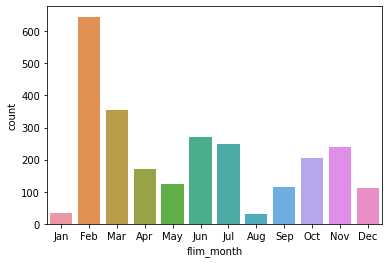

In [17]:
month_ted_talks_pandas = month_ted_talks.toPandas()
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
sns.barplot(x='flim_month', y='count', data=month_ted_talks_pandas, order = month_order)

February is clearly the most popular month for TED Conferences whereas August and January are the least popular. February's popularity is largely due to the fact that the official TED Conferences are held in February. Let us check the distribution for TEDx talks only.

In [18]:
tedX_events = pyspark_ted_talks.filter(pyspark_ted_talks.event.contains("TEDx")) 
tedX_month = tedX_events.groupBy('flim_month').count().orderBy('count', ascending = False)
tedX_month.show()

+----------+-----+
|flim_month|count|
+----------+-----+
|       Nov|  103|
|       Oct|   65|
|       Apr|   55|
|       Sep|   54|
|       May|   42|
|       Jun|   35|
|       Mar|   33|
|       Feb|   23|
|       Jan|   21|
|       Dec|   18|
|       Jul|   12|
|       Aug|   10|
+----------+-----+



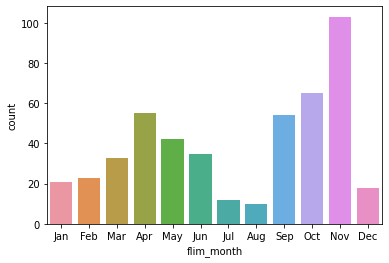

In [19]:
tedX_month_pandas = tedX_month.toPandas()
sns.barplot(x='flim_month', y='count', data=tedX_month_pandas, order=month_order)

### Most popular days for conducting TED conferences

In [20]:
dayName = udf(lambda z: todayName(z), StringType())
spark.udf.register("dayName", dayName)

def todayName(dayNo):
    return calendar.day_name[dayNo-1][0:3]

pyspark_ted_talks = pyspark_ted_talks.withColumn('day_of_week', dayofweek(pyspark_ted_talks.film_date))
pyspark_ted_talks = pyspark_ted_talks.withColumn('day',dayName('day_of_week'))
day_ted_talks = pyspark_ted_talks.groupBy('day').count().orderBy('count', ascending = False)
day_ted_talks.show()

+---+-----+
|day|count|
+---+-----+
|Thu|  551|
|Wed|  534|
|Fri|  382|
|Sat|  339|
|Tue|  326|
|Mon|  306|
|Sun|  112|
+---+-----+



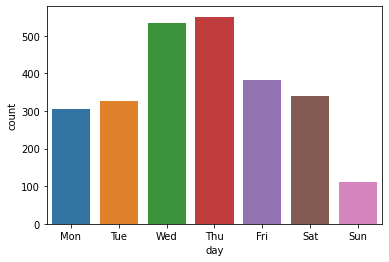

In [21]:
day_ted_talks_pandas = day_ted_talks.toPandas()
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
sns.barplot(x='day', y='count', data=day_ted_talks_pandas, order=day_order)

As seen from the bar chart most common days for ted talks is Thursday followed by Wednesday, this is against the popular notion that people might have that most ted conferences are over weekends

### Number of TED talks through the years

In [22]:
pyspark_ted_talks = pyspark_ted_talks.withColumn('year', year(pyspark_ted_talks.film_date))
year_ted_talks = pyspark_ted_talks.groupBy('year').count().orderBy('count', ascending = False)
year_ted_talks.show()

+----+-----+
|year|count|
+----+-----+
|2013|  270|
|2011|  270|
|2012|  267|
|2010|  267|
|2016|  246|
|2015|  239|
|2014|  237|
|2009|  232|
|2007|  112|
|2017|   98|
|2008|   84|
|2005|   66|
|2006|   52|
|2003|   33|
|2004|   33|
|2002|   27|
|1998|    6|
|2001|    5|
|1984|    1|
|1991|    1|
+----+-----+
only showing top 20 rows



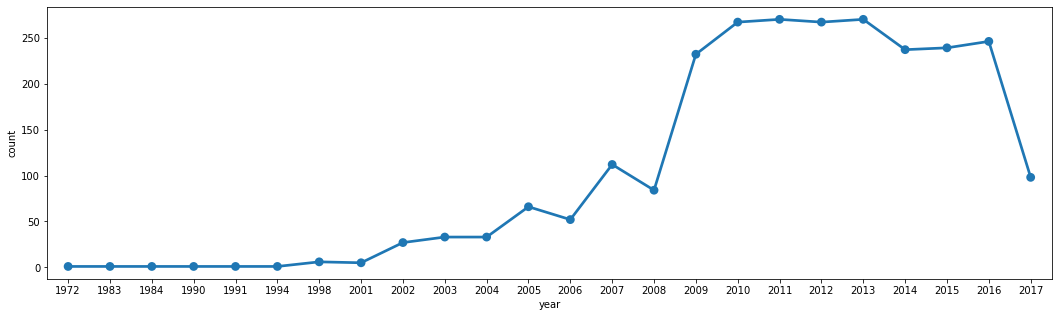

In [23]:
year_ted_talks_pandas = year_ted_talks.toPandas()
plt.figure(figsize=(18,5))
sns.pointplot(x='year', y='count', data=year_ted_talks_pandas)

The Ted talks were gradually increasing ever since it started, there seem to be a sharp rise in number of ted talks from 2009 and is pertty much constant since then.
Since the data for 2017 is only till september we see a decline in graph which we can ignore.

### TED Speakers and their Occupation

In [24]:
speaker = pyspark_ted_talks.groupBy('main_speaker').count()
speaker = speaker.sort('count', ascending = False)
speaker.show()

+--------------------+-----+
|        main_speaker|count|
+--------------------+-----+
|        Hans Rosling|    9|
|       Juan Enriquez|    7|
|               Rives|    6|
|       Marco Tempest|    6|
| Nicholas Negroponte|    5|
|          Bill Gates|    5|
|     Julian Treasure|    5|
|Jacqueline Novogratz|    5|
|         Clay Shirky|    5|
|          Dan Ariely|    5|
|     Lawrence Lessig|    4|
|        Ken Robinson|    4|
|             Al Gore|    4|
|      Jonathan Haidt|    4|
|   Stefan Sagmeister|    4|
|           Tom Wujec|    4|
|      Chris Anderson|    4|
|      Barry Schwartz|    4|
|          Eve Ensler|    4|
|       Stewart Brand|    4|
+--------------------+-----+
only showing top 20 rows



In [25]:
occupation = pyspark_ted_talks.groupBy('speaker_occupation').count()
occupation = occupation.sort('count', ascending = False)
occupation.show()

+------------------+-----+
|speaker_occupation|count|
+------------------+-----+
|            Writer|   45|
|            Artist|   34|
|          Designer|   34|
|        Journalist|   33|
|      Entrepreneur|   31|
|         Architect|   30|
|          Inventor|   27|
|      Psychologist|   26|
|      Photographer|   25|
|         Filmmaker|   21|
|            Author|   20|
|    Neuroscientist|   20|
|         Economist|   20|
|          Educator|   20|
|       Philosopher|   16|
|        Roboticist|   16|
|         Biologist|   15|
|         Physicist|   14|
|          Musician|   11|
|  Marine biologist|   11|
+------------------+-----+
only showing top 20 rows



1. Writers top the chart for ted talks speaker occupation follwed by Artists and Designers
2. Hans Rosling has most number of ted talks with 9

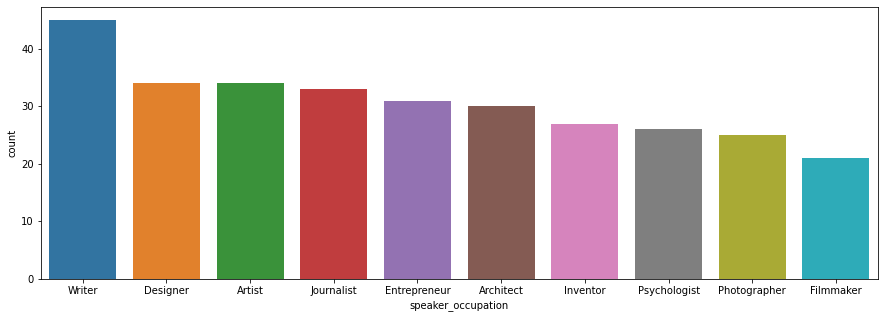

In [26]:
occupation_pandas = occupation.toPandas()
plt.figure(figsize=(15,5))
sns.barplot(x='speaker_occupation', y='count', data=occupation_pandas.head(10))
plt.show()

Checking which profession gets most views on ted talks

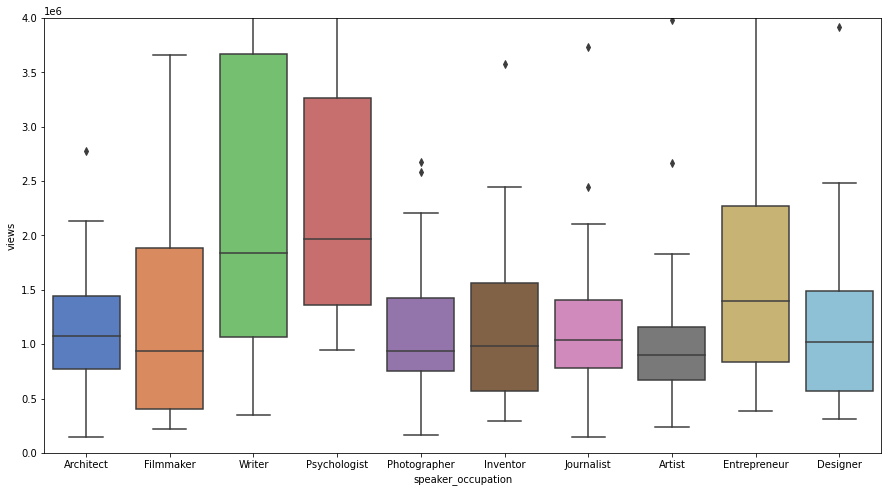

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
sns.boxplot(x='speaker_occupation', y='views', data=ted_talks_pandas[ted_talks_pandas['speaker_occupation'].isin(occupation_pandas.head(10)['speaker_occupation'])], palette="muted", ax =ax)
ax.set_ylim([0, 0.4e7])
plt.show()

On average, out of the top 10 most popular professions, Psychologists tend to garner the most views on avegare just less than 2 million.
Writers have the greatest range of views

In [28]:
pyspark_ted_talks.groupBy('num_speaker').count().show()

+-----------+-----+
|num_speaker|count|
+-----------+-----+
|          1| 2492|
|          3|    5|
|          5|    1|
|          4|    3|
|          2|   49|
+-----------+-----+



In [29]:
 pyspark_ted_talks.filter(pyspark_ted_talks.num_speaker == 5).select('title', 'description', 'main_speaker', 'event').show() 

+--------------------+--------------------+--------------------+-------+
|               title|         description|        main_speaker|  event|
+--------------------+--------------------+--------------------+-------+
|A dance to honor ...|Movement artists ...|Jon Boogz and Lil...|TED2017|
+--------------------+--------------------+--------------------+-------+



Almost all ted talks had only one main speaker, the only talk with 5 differnet spreaks actually turned out to be a dace perfomance which makes sense.

### TED Events

In [30]:
ted_events = pyspark_ted_talks.select('title', 'event').groupBy('event').count()
ted_events = ted_events.sort('count', ascending = False)
ted_events.show()

+--------------+-----+
|         event|count|
+--------------+-----+
|       TED2014|   84|
|       TED2009|   83|
|       TED2013|   77|
|       TED2016|   77|
|       TED2015|   75|
|       TED2011|   70|
|TEDGlobal 2012|   70|
|TEDGlobal 2011|   68|
|       TED2007|   68|
|       TED2010|   68|
|       TED2017|   67|
|TEDGlobal 2013|   66|
|TEDGlobal 2009|   65|
|       TED2012|   65|
|       TED2008|   57|
|TEDGlobal 2010|   55|
|TEDGlobal 2014|   51|
|       TED2006|   45|
|       TED2005|   37|
| TEDIndia 2009|   35|
+--------------+-----+
only showing top 20 rows



The official TED events held the major share of TED Talks published on the TED.com platform. TED2014 had the most number of talks followed by TED2009

### Ted Languages

In [31]:
pyspark_ted_talks.select('languages').describe().show()

+-------+------------------+
|summary|         languages|
+-------+------------------+
|  count|              2550|
|   mean|27.326274509803923|
| stddev| 9.563451653845624|
|    min|                 0|
|    max|                72|
+-------+------------------+



In [32]:
print("Correaltion between Languages and views: "+ str(pyspark_ted_talks.stat.corr("languages", "views")))

Correaltion between Languages and views: 0.3776230522531861


In [33]:
 pyspark_ted_talks.filter(pyspark_ted_talks.languages == 72).select('title', 'description', 'main_speaker', 'event').show() 

+--------------------+--------------------+------------+-------+
|               title|         description|main_speaker|  event|
+--------------------+--------------------+------------+-------+
|Try something new...|Is there somethin...|  Matt Cutts|TED2011|
+--------------------+--------------------+------------+-------+



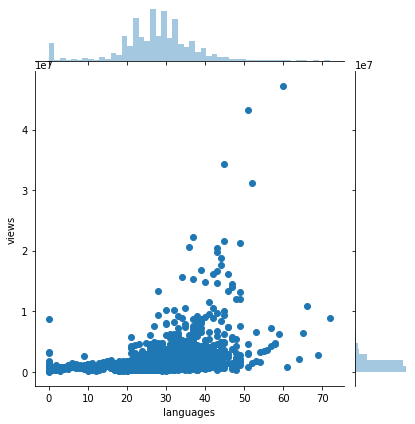

In [34]:
sns.jointplot(x='languages', y='views', data=ted_talks_pandas)
plt.show()

On average, a TED Talk is available in 27 different languages. The maximum number of languages a TED Talk is available in is a staggering 72.

The ted talk with 72 languages is Matt Cutts: Try something new for 30 days

The Pearson coefficient between number of languages and views is 0.38 suggesting a medium correlation

### TED Themes

In [35]:
convert = udf(lambda z: conv(z), StringType())
spark.udf.register("convert", convert)

def conv(z):
    z = z.replace('[','')
    z = z.replace(']','')
    return z

pyspark_ted_talks = pyspark_ted_talks.withColumn('theme',convert('tags'))
theme_df = pyspark_ted_talks.select(col("title"), explode(split(col("theme"), ",\s*")))
theme_df = theme_df.groupby('col').count().orderBy('count', ascending = False)

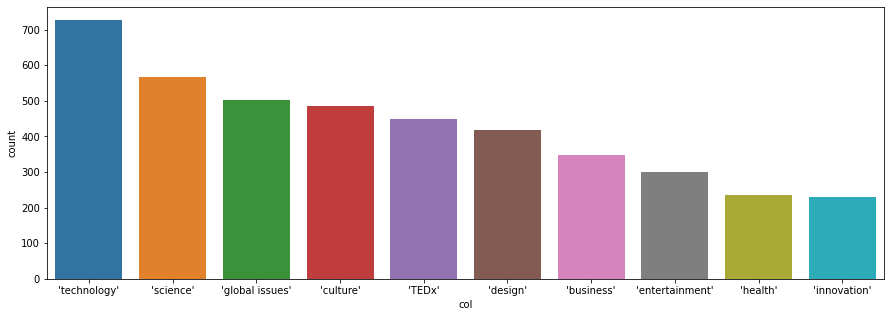

In [36]:
theme_pandas = theme_df.toPandas()
plt.figure(figsize=(15,5))
sns.barplot(x='col', y='count', data=theme_pandas.head(10))
plt.show()

1. Technology and Science are the most popular themes for talks followed by global issues and culture
2. innovation and health just make the top 10 list
3. TedX is included in tags column of dataset but can be ignored as it is not a theme

### Talk Duration

In [37]:
#Convert to minutes
pyspark_ted_talks = pyspark_ted_talks.withColumn('duration',pyspark_ted_talks.duration/60)
pyspark_ted_talks.select('duration').describe().show()

+-------+------------------+
|summary|          duration|
+-------+------------------+
|  count|              2550|
|   mean|13.775169934640523|
| stddev| 6.233485633648684|
|    min|              2.25|
|    max|              87.6|
+-------+------------------+



In [38]:
print("Correlation between duration of Ted Talks and Views: " + str(pyspark_ted_talks.stat.corr("duration", "views")))

Correlation between duration of Ted Talks and Views: 0.0487404290479599


In [39]:
 pyspark_ted_talks.filter(pyspark_ted_talks.duration == 2.25).select('title', 'description', 'main_speaker', 'event').show()

+--------------------+--------------------+----------------+-------+
|               title|         description|    main_speaker|  event|
+--------------------+--------------------+----------------+-------+
|The ancestor of l...|After speaking at...|Murray Gell-Mann|TED2007|
+--------------------+--------------------+----------------+-------+



In [40]:
 pyspark_ted_talks.filter(pyspark_ted_talks.duration == 87.6).select('title', 'description', 'main_speaker', 'event').show()

+--------------------+--------------------+-------------+--------------------+
|               title|         description| main_speaker|               event|
+--------------------+--------------------+-------------+--------------------+
|Parrots, the univ...|Blind river dolph...|Douglas Adams|University of Cal...|
+--------------------+--------------------+-------------+--------------------+



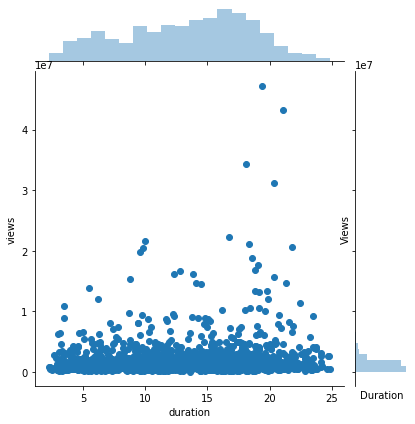

In [41]:
ted_talks_pandas['duration'] = ted_talks_pandas['duration']/60
sns.jointplot(x='duration', y='views', data=ted_talks_pandas[ted_talks_pandas['duration'] < 25])
plt.xlabel('Duration')
plt.ylabel('Views')
plt.show()

TED Talks, on average are 13.7 minutes long. This is surprising because TED Talks are often synonymous with 18-20 minutes and the average is a good 3 minutes shorter than that.

The shortest TED Talk on record is 2.25 minutes long whereas the longest talk is 87.6 minutes long. 

The shortest talk was at TED2007 titled The ancestor of language by Murray Gell-Mann. The longest talk on TED.com is not a TED Talk but a flim uploaded on Ted.com website called Parrots, the universe and everything delivered by Douglas Adams at the University of California in 2001.

There seems to be almost no correlation between duration and number of views of ted talks which is very odd as it is always the nothing that longer viedos might have less views but content seem to be force behind views of Ted talks

## Word Count

In [42]:
#convert pandas dataframe into spark dataframe 
tedScriptSchema = StructType([ StructField("transcript", StringType(), True)\
                       ,StructField("url", StringType(), True)])

pyspark_ted_scripts = sqlCtx.createDataFrame(ted_scripts_pandas[['transcript', 'url']],schema=tedScriptSchema)
pyspark_ted_scripts

DataFrame[transcript: string, url: string]

In [43]:
pyspark_ted_scripts.show(1)

+--------------------+--------------------+
|          transcript|                 url|
+--------------------+--------------------+
|Good morning. How...|https://www.ted.c...|
+--------------------+--------------------+
only showing top 1 row



In [44]:
ted_scripts_merged = pyspark_ted_talks.join(pyspark_ted_scripts, on=['url'], how='left')

In [45]:
ted_scripts_merged.select('name','title','transcript').show(10)

+--------------------+--------------------+--------------------+
|                name|               title|          transcript|
+--------------------+--------------------+--------------------+
|Ahn Trio: A moder...|A modern take on ...|(Applause)(Music)...|
|Al Vernacchio: Se...|Sex needs a new m...|I'd like to talk ...|
|Alan Kay: A power...|A powerful idea a...|A great way to st...|
|Alejandro Aravena...|My architectural ...|If there's any po...|
|Ameenah Gurib-Fak...|Humble plants tha...|You know, it's a ...|
|Amy Adele Hasinof...|How to practice s...|People have been ...|
|Arianna Huffingto...|How to succeed? G...|My big idea is a ...|
|Bjarke Ingels: He...|Hedonistic sustai...|                null|
|Christien Meinder...|How pig parts mak...|Hello. I would li...|
|Dean Kamen: Luke,...|Luke, a new prost...|I got a visit alm...|
+--------------------+--------------------+--------------------+
only showing top 10 rows



In [46]:
wordcount = udf(lambda z: wc(z), IntegerType())
spark.udf.register("wordcount", wordcount)

def wc(z):
    if z is None:
        return 0
    else:
        return len(z.split())

ted_scripts_merged=ted_scripts_merged.withColumn('word_count',wordcount('transcript'))

In [47]:
ted_scripts_merged.select('name','transcript','word_count').show(10)

+--------------------+--------------------+----------+
|                name|          transcript|word_count|
+--------------------+--------------------+----------+
|Ahn Trio: A moder...|(Applause)(Music)...|       120|
|Al Vernacchio: Se...|I'd like to talk ...|      1235|
|Alan Kay: A power...|A great way to st...|      2868|
|Alejandro Aravena...|If there's any po...|      2047|
|Ameenah Gurib-Fak...|You know, it's a ...|      2007|
|Amy Adele Hasinof...|People have been ...|      1947|
|Arianna Huffingto...|My big idea is a ...|       497|
|Bjarke Ingels: He...|                null|         0|
|Christien Meinder...|Hello. I would li...|      1498|
|Dean Kamen: Luke,...|I got a visit alm...|       772|
+--------------------+--------------------+----------+
only showing top 10 rows



In [48]:
ted_scripts_merged.select('word_count').describe().show()

+-------+------------------+
|summary|        word_count|
+-------+------------------+
|  count|              2553|
|   mean|1971.5507246376812|
| stddev|1009.4943292636673|
|    min|                 0|
|    max|              9044|
+-------+------------------+



Average TED Talk has around 1971 words and there is a significantly large standard deviation of a 1009 words. The longest talk is 9044 words in length.

Like duration, there shouldn't be any correlation between number of words and views.
so checking the number of words per minute of ted speakers

In [49]:
ted_scripts_merged = ted_scripts_merged.withColumn('word_per_min', ted_scripts_merged.word_count/ted_scripts_merged.duration)

In [50]:
ted_scripts_merged.select('word_per_min').describe().show()

+-------+------------------+
|summary|      word_per_min|
+-------+------------------+
|  count|              2553|
|   mean|142.14775245831495|
| stddev| 39.63534807961172|
|    min|               0.0|
|    max|247.36486486486484|
+-------+------------------+



The average TED Speaker enunciates 142 words per minute. The fastest talker spoke a staggering 247 words a minute which is much higher than the average of 125-150 words per minute in English.

### Ted Ratings

In [51]:
rating_parameters = set()
ratings = ast.literal_eval(pyspark_ted_talks.collect()[0]['ratings'])
for i in range(len(ratings)):
    rating_parameters.add(ratings[i]['name'])
rating_parameters 

{'Beautiful',
 'Confusing',
 'Courageous',
 'Fascinating',
 'Funny',
 'Informative',
 'Ingenious',
 'Inspiring',
 'Jaw-dropping',
 'Longwinded',
 'OK',
 'Obnoxious',
 'Persuasive',
 'Unconvincing'}

The above list represents the Rating categories on ted.com website to rate each ted talk

In [52]:
convert_ratings = udf(lambda z: to_array(z), StringType())
spark.udf.register("convert_ratings", convert_ratings)

def to_array(z):
    return ast.literal_eval(z)
pyspark_ted_talks = pyspark_ted_talks.withColumn("ratings_converted", convert_ratings('ratings'))
pyspark_ted_talks = pyspark_ted_talks.drop("ratings")
pyspark_ted_talks = pyspark_ted_talks.withColumnRenamed('ratings_converted', 'ratings')
pyspark_ted_talks

DataFrame[comments: bigint, description: string, duration: double, event: string, languages: int, main_speaker: string, name: string, num_speaker: int, related_talks: string, speaker_occupation: string, tags: string, title: string, url: string, views: bigint, film_date: string, published_date: string, dis_quo: double, flim_month_no: int, flim_month: string, day_of_week: int, day: string, year: int, theme: string, ratings: string]

In [53]:
Funny = udf(lambda z: funny_count(z), IntegerType())
spark.udf.register("Funny", Funny)
def funny_count(z):
    for i in range(len(z)):
        if z[i]['name'] == 'Funny':
            return z[i]['count']
    return 0

Beautiful = udf(lambda z: Beautiful_count(z), IntegerType())
spark.udf.register("Beautiful", Beautiful)
def Beautiful_count(z):
    for i in range(len(z)):
        if z[i]['name'] == 'Beautiful':
            return z[i]['count']
    return 0

Ingenious = udf(lambda z: Ingenious_count(z), IntegerType())
spark.udf.register("Ingenious", Ingenious)
def Ingenious_count(z):
    for i in range(len(z)):
        if z[i]['name'] == 'Ingenious':
            return z[i]['count']
    return 0

Courageous = udf(lambda z: Courageous_count(z), IntegerType())
spark.udf.register("Courageous", Courageous)
def Courageous_count(z):
    for i in range(len(z)):
        if z[i]['name'] == 'Courageous':
            return z[i]['count']
    return 0

Longwinded = udf(lambda z: Longwinded_count(z), IntegerType())
spark.udf.register("Longwinded", Longwinded)
def Longwinded_count(z):
    for i in range(len(z)):
        if z[i]['name'] == 'Longwinded':
            return z[i]['count']
    return 0

Confusing = udf(lambda z: Confusing_count(z), IntegerType())
spark.udf.register("Confusing", Confusing)
def Confusing_count(z):
    for i in range(len(z)):
        if z[i]['name'] == 'Confusing':
            return z[i]['count']
    return 0

Informative = udf(lambda z: Informative_count(z), IntegerType())
spark.udf.register("Informative", Informative)
def Informative_count(z):
    for i in range(len(z)):
        if z[i]['name'] == 'Informative':
            return z[i]['count']
    return 0

Fascinating = udf(lambda z: Fascinating_count(z), IntegerType())
spark.udf.register("Fascinating", Fascinating)	
def Fascinating_count(z):
    for i in range(len(z)):
        if z[i]['name'] == 'Fascinating':
            return z[i]['count']
    return 0

Unconvincing = udf(lambda z: Unconvincing_count(z), IntegerType())
spark.udf.register("Unconvincing", Unconvincing)
def Unconvincing_count(z):
    for i in range(len(z)):
        if z[i]['name'] == 'Unconvincing':
            return z[i]['count']
    return 0


Persuasive = udf(lambda z: Persuasive_count(z), IntegerType())
spark.udf.register("Persuasive", Persuasive)
def Persuasive_count(z):
    for i in range(len(z)):
        if z[i]['name'] == 'Persuasive':
            return z[i]['count']
    return 0

Jaw_dropping = udf(lambda z: Jaw_dropping_count(z), IntegerType())
spark.udf.register("Jaw_dropping", Jaw_dropping)
def Jaw_dropping_count(z):
    for i in range(len(z)):
        if z[i]['name'] == 'Jaw-dropping':
            return z[i]['count']
    return 0

OK = udf(lambda z: OK_count(z), IntegerType())
spark.udf.register("OK", OK)
def OK_count(z):
    for i in range(len(z)):
        if z[i]['name'] == 'OK':
            return z[i]['count']
    return 0
    
Obnoxious = udf(lambda z: Obnoxious_count(z), IntegerType())
spark.udf.register("Obnoxious", Obnoxious)
def Obnoxious_count(z):
    for i in range(len(z)):
        if z[i]['name'] == 'Obnoxious':
            return z[i]['count']
    return 0

Inspiring = udf(lambda z: Inspiring_count(z), IntegerType())
spark.udf.register("Inspiring", Inspiring)
def Inspiring_count(z):
    for i in range(len(z)):
        if z[i]['name'] == 'Inspiring':
            return z[i]['count']
    return 0

In [54]:
pyspark_ted_talks = pyspark_ted_talks.withColumn("Funny", Funny('ratings'))
pyspark_ted_talks = pyspark_ted_talks.withColumn("Beautiful", Beautiful('ratings'))
pyspark_ted_talks = pyspark_ted_talks.withColumn("Ingenious", Ingenious('ratings'))
pyspark_ted_talks = pyspark_ted_talks.withColumn("Courageous", Courageous('ratings'))
pyspark_ted_talks = pyspark_ted_talks.withColumn("Longwinded", Longwinded('ratings'))
pyspark_ted_talks = pyspark_ted_talks.withColumn("Confusing", Confusing('ratings'))
pyspark_ted_talks = pyspark_ted_talks.withColumn("Informative", Informative('ratings'))
pyspark_ted_talks = pyspark_ted_talks.withColumn("Fascinating", Fascinating('ratings'))
pyspark_ted_talks = pyspark_ted_talks.withColumn("Unconvincing", Unconvincing('ratings'))
pyspark_ted_talks = pyspark_ted_talks.withColumn("Persuasive", Persuasive('ratings'))
pyspark_ted_talks = pyspark_ted_talks.withColumn("Jaw_dropping", Jaw_dropping('ratings'))
pyspark_ted_talks = pyspark_ted_talks.withColumn("OK", OK('ratings'))
pyspark_ted_talks = pyspark_ted_talks.withColumn("Obnoxious", Obnoxious('ratings'))
pyspark_ted_talks = pyspark_ted_talks.withColumn("Inspiring", Inspiring('ratings'))
pyspark_ted_talks

DataFrame[comments: bigint, description: string, duration: double, event: string, languages: int, main_speaker: string, name: string, num_speaker: int, related_talks: string, speaker_occupation: string, tags: string, title: string, url: string, views: bigint, film_date: string, published_date: string, dis_quo: double, flim_month_no: int, flim_month: string, day_of_week: int, day: string, year: int, theme: string, ratings: string, Funny: int, Beautiful: int, Ingenious: int, Courageous: int, Longwinded: int, Confusing: int, Informative: int, Fascinating: int, Unconvincing: int, Persuasive: int, Jaw_dropping: int, OK: int, Obnoxious: int, Inspiring: int]

In [55]:
pyspark_ted_talks.select('name','Funny','Beautiful','Ingenious','Inspiring').show(10)

+--------------------+-----+---------+---------+---------+
|                name|Funny|Beautiful|Ingenious|Inspiring|
+--------------------+-----+---------+---------+---------+
|Ken Robinson: Do ...|19645|     4573|     6073|    24924|
|Al Gore: Averting...|  544|       58|       56|      413|
|David Pogue: Simp...|  964|       60|      183|      230|
|Majora Carter: Gr...|   59|      291|      105|     1070|
|Hans Rosling: The...| 1390|      942|     3202|     2893|
|Tony Robbins: Why...| 1102|      706|      397|     5211|
|Julia Sweeney: Le...| 2484|      277|      320|      438|
|Joshua Prince-Ram...|    9|       98|      195|      175|
|Dan Dennett: Let'...|   60|      145|      211|      441|
|Rick Warren: A li...|   26|      767|      116|     2556|
+--------------------+-----+---------+---------+---------+
only showing top 10 rows



### Top 10 Funniest Talks of all time


In [56]:
pyspark_ted_talks.select('title', 'main_speaker', 'views', 'published_date', 'Funny').orderBy("Funny", ascending=False).show(10)

+--------------------+------------------+--------+--------------+-----+
|               title|      main_speaker|   views|published_date|Funny|
+--------------------+------------------+--------+--------------+-----+
|Do schools kill c...|      Ken Robinson|47227110|    2006-06-26|19645|
|This is what happ...|      James Veitch|20475972|    2016-01-08| 7731|
|Inside the mind o...|         Tim Urban|14745406|    2016-03-15| 7445|
|The happy secret ...|       Shawn Achor|16209727|    2012-02-01| 7315|
|Lies, damned lies...|Sebastian Wernicke| 2212944|    2010-04-30| 5552|
|The power of vuln...|       Brené Brown|31168150|    2010-12-23| 5225|
|10 things you did...|        Mary Roach|22270883|    2009-05-19| 4166|
|It's time for "Th...|     Julia Sweeney| 3362099|    2010-05-14| 4025|
|Did you hear the ...|       Maz Jobrani| 4646183|    2010-08-19| 4013|
|Bring on the lear...|      Ken Robinson| 7266316|    2010-05-24| 3000|
+--------------------+------------------+--------+--------------

### Top 10 Jaw dropping Talks of all time

In [57]:
pyspark_ted_talks.select('title', 'main_speaker', 'views', 'published_date', 'Jaw_dropping').orderBy("Jaw_dropping", ascending=False).show(10)

+--------------------+--------------------+--------+--------------+------------+
|               title|        main_speaker|   views|published_date|Jaw_dropping|
+--------------------+--------------------+--------+--------------+------------+
|How PhotoSynth ca...|Blaise Agüera y A...| 4772595|    2007-05-26|       14728|
|My stroke of insight|   Jill Bolte Taylor|21190883|    2008-03-11|       10464|
|The thrilling pot...|       Pranav Mistry|16097077|    2009-11-15|        8416|
|Underwater astoni...|         David Gallo|13926113|    2008-01-10|        8328|
|A performance of ...|     Arthur Benjamin| 8360707|    2007-12-12|        7196|
|New insights on p...|        Hans Rosling| 3243784|    2007-06-25|        5137|
|      This is Saturn|       Carolyn Porco| 2627709|    2007-09-30|        4971|
|The radical promi...|            Jeff Han| 4531020|    2006-07-31|        4643|
|Do schools kill c...|        Ken Robinson|47227110|    2006-06-26|        4439|
|The best stats yo...|      

### Top 10 Beautiful Talks of all time

In [58]:
pyspark_ted_talks.select('title', 'main_speaker', 'views', 'published_date', 'Beautiful').orderBy("Beautiful", ascending=False).show(10)

+--------------------+--------------------+--------+--------------+---------+
|               title|        main_speaker|   views|published_date|Beautiful|
+--------------------+--------------------+--------+--------------+---------+
|My stroke of insight|   Jill Bolte Taylor|21190883|    2008-03-11|     9437|
|The power of vuln...|         Brené Brown|31168150|    2010-12-23|     7942|
|Building a park i...|      Robert Hammond|  704205|    2011-06-30|     6685|
|The transformativ...|     Benjamin Zander| 9315483|    2008-06-24|     5967|
|The danger of a s...|Chimamanda Ngozi ...|13298341|    2009-10-06|     5607|
|Underwater astoni...|         David Gallo|13926113|    2008-01-10|     5201|
|Do schools kill c...|        Ken Robinson|47227110|    2006-06-26|     4573|
|If I should have ...|           Sarah Kay|10529854|    2011-03-18|     4430|
|Nature. Beauty. G...|  Louie Schwartzberg| 3658158|    2012-11-22|     4399|
|Your elusive crea...|   Elizabeth Gilbert|13155478|    2009-02-

### Top 10 Inspiring Talks of all time

In [59]:
pyspark_ted_talks.select('title', 'main_speaker', 'views', 'published_date', 'Inspiring').orderBy("Inspiring", ascending=False).show(10)

+--------------------+--------------------+--------+--------------+---------+
|               title|        main_speaker|   views|published_date|Inspiring|
+--------------------+--------------------+--------+--------------+---------+
|Do schools kill c...|        Ken Robinson|47227110|    2006-06-26|    24924|
|How great leaders...|         Simon Sinek|34309432|    2010-05-04|    21564|
|The power of vuln...|         Brené Brown|31168150|    2010-12-23|    21444|
|Your body languag...|           Amy Cuddy|43155405|    2012-10-01|    21210|
|How to live befor...|          Steve Jobs| 8744428|    2011-10-05|    17290|
|My stroke of insight|   Jill Bolte Taylor|21190883|    2008-03-11|    16918|
|Why we all need t...|           Guy Winch| 4984884|    2015-02-16|    13398|
|The happy secret ...|         Shawn Achor|16209727|    2012-02-01|    11213|
|The power of intr...|          Susan Cain|17629275|    2012-03-02|    10218|
|The danger of a s...|Chimamanda Ngozi ...|13298341|    2009-10-

### Top 10 Confusing Talks of all time

In [60]:
pyspark_ted_talks.select('title', 'main_speaker', 'views', 'published_date', 'Confusing').orderBy("Confusing", ascending=False).show(10)

+--------------------+-----------------+--------+--------------+---------+
|               title|     main_speaker|   views|published_date|Confusing|
+--------------------+-----------------+--------+--------------+---------+
|I believe we evol...|    Elaine Morgan| 1038576|    2009-07-30|      531|
|An 8-dimensional ...|     Garrett Lisi| 1491698|    2008-10-13|      376|
|Why we do what we do|     Tony Robbins|20685401|    2006-06-27|      301|
|My stroke of insight|Jill Bolte Taylor|21190883|    2008-03-11|      289|
|   The call to learn|   Clifford Stoll| 2283491|    2008-03-25|      278|
|  Design and destiny|  Philippe Starck| 1783740|    2007-12-03|      276|
|         Brain magic|      Keith Barry|13327101|    2008-07-18|      273|
|17 words of archi...| Daniel Libeskind|  784642|    2009-06-30|      244|
|Do schools kill c...|     Ken Robinson|47227110|    2006-06-26|      242|
|The surprising sc...|      Dan Gilbert|14689301|    2006-09-25|      241|
+--------------------+---

### Finding Total number of ratings for each Ted Talk

In [61]:
pyspark_ted_talks = pyspark_ted_talks.withColumn('total_rating', pyspark_ted_talks.Funny + pyspark_ted_talks.Beautiful + pyspark_ted_talks.Ingenious + 
                   pyspark_ted_talks.Courageous + pyspark_ted_talks.Longwinded + pyspark_ted_talks.Confusing + pyspark_ted_talks.Informative + 
                   pyspark_ted_talks.Fascinating + pyspark_ted_talks.Unconvincing + pyspark_ted_talks.Persuasive + pyspark_ted_talks.Jaw_dropping + 
                   pyspark_ted_talks.OK + pyspark_ted_talks.Obnoxious + pyspark_ted_talks.Inspiring)
pyspark_ted_talks.select('name','total_rating').show(10)

+--------------------+------------+
|                name|total_rating|
+--------------------+------------+
|Ken Robinson: Do ...|       93850|
|Al Gore: Averting...|        2936|
|David Pogue: Simp...|        2824|
|Majora Carter: Gr...|        3728|
|Hans Rosling: The...|       25620|
|Tony Robbins: Why...|       15356|
|Julia Sweeney: Le...|        5998|
|Joshua Prince-Ram...|        1024|
|Dan Dennett: Let'...|        3946|
|Rick Warren: A li...|        8327|
+--------------------+------------+
only showing top 10 rows



Checking the range of the total number of votes.

In [62]:
pyspark_ted_talks.groupby().max('total_rating').first().asDict()

{'max(total_rating)': 93850}

In [63]:
pyspark_ted_talks.groupby().min('total_rating').first().asDict()

{'min(total_rating)': 68}

The talk with fewer votes has 68.
The talk with most votes has 93850.

### Frequency of each qualitative rating, with the positive descriptors in Blue and negative ones in red

In [64]:
Total_ratings = {}
for field in pyspark_ted_talks.columns:
    if field in rating_parameters:
        total_count = pyspark_ted_talks.agg(F.sum(col(field))).collect()[0][0]
        Total_ratings[field] = total_count
Total_ratings

{'Funny': 393895,
 'Beautiful': 490349,
 'Ingenious': 384386,
 'Courageous': 420045,
 'Longwinded': 83344,
 'Confusing': 53436,
 'Informative': 887434,
 'Fascinating': 801119,
 'Unconvincing': 134558,
 'Persuasive': 561220,
 'OK': 207157,
 'Obnoxious': 66303,
 'Inspiring': 1352048}

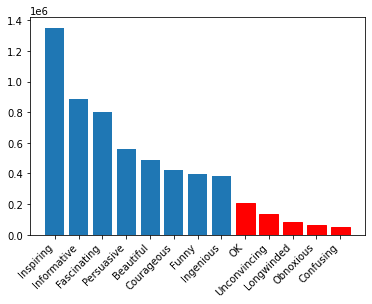

In [65]:
sum_ratings = pd.DataFrame.from_dict(Total_ratings,orient='index',columns=['Count'])
sum_ratings.index.names = ['Rating']
sum_ratings = sum_ratings.sort_values('Count', ascending = False)
frequencies = list(Total_ratings.values())
descr = Total_ratings.keys()
descriptors = [x for _,x in sorted(zip(frequencies,Total_ratings.keys()), reverse=True)]
neg_descriptors = {"Confusing", "Unconvincing", "Longwinded", "Obnoxious", "OK"}
neg_indices  = [x for x in range (len(descriptors)) if descriptors[x] in neg_descriptors]
frequencies.sort(reverse=True)
indices = np.arange(len(descriptors))
bar = plt.bar(indices, frequencies, 0.8)
[bar[i].set_color('r') for i in neg_indices]
plt.xticks(indices, descriptors, rotation=45, ha="right")
plt.show()

### Finding what percentage out of total rating was each rating

In [66]:
percent_rating = pyspark_ted_talks
for field in pyspark_ted_talks.columns:
    if field in rating_parameters:
        percent_rating = percent_rating.withColumn(field, (col(field) / col("total_rating")*100))

In [67]:
percent_rating.select('name','Funny','Beautiful','Inspiring','Longwinded',
          'Informative').show(1)

+--------------------+-----------------+-----------------+-----------------+------------------+-----------------+
|                name|            Funny|        Beautiful|        Inspiring|        Longwinded|      Informative|
+--------------------+-----------------+-----------------+-----------------+------------------+-----------------+
|Ken Robinson: Do ...|20.93233883857219|4.872669152903569|26.55727224294086|0.4123601491742142|7.827384123601491|
+--------------------+-----------------+-----------------+-----------------+------------------+-----------------+
only showing top 1 row



### The Main Rating 

One additional feature will be added to the dataframe: the main rating. This variable will indicate the rating with most votes for each talk. This is going to be the main characteristic used to compare the rating with the other features.

In [68]:
only_rating = pyspark_ted_talks.select('Funny','Beautiful','Ingenious','Longwinded',
               'Confusing','Informative','Fascinating','Unconvincing',
               'Persuasive','OK','Obnoxious','Inspiring')

In [69]:
import pyspark.sql.functions as psf
cond = "psf.when" + ".when".join(["(psf.col('" + c + "') == psf.col('max_value'), psf.lit('" + c + "'))" for c in only_rating.columns])
only_rating = only_rating.withColumn("max_value", psf.greatest(*only_rating.columns))\
    .withColumn("Main_Rating", eval(cond))

In [70]:
only_rating.select('Main_Rating').show(10)

+-----------+
|Main_Rating|
+-----------+
|  Inspiring|
|      Funny|
|      Funny|
|  Inspiring|
|Informative|
|  Inspiring|
|      Funny|
|  Ingenious|
| Persuasive|
|  Inspiring|
+-----------+
only showing top 10 rows



The following plot will show how many talks have each main rating.

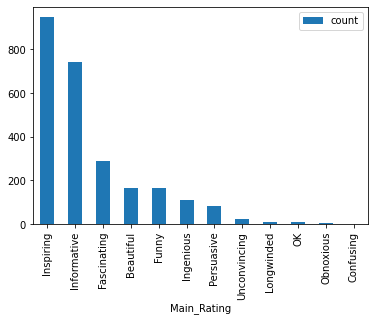

In [71]:
main_rating = only_rating.groupBy('Main_Rating').count()
main_rating = main_rating.orderBy('count',ascending = False)
main_rating.toPandas().plot.bar(x = 'Main_Rating', y = 'count' )

In [72]:
main_rating.show()

+------------+-----+
| Main_Rating|count|
+------------+-----+
|   Inspiring|  949|
| Informative|  742|
| Fascinating|  291|
|   Beautiful|  167|
|       Funny|  165|
|   Ingenious|  109|
|  Persuasive|   83|
|Unconvincing|   23|
|  Longwinded|    8|
|          OK|    7|
|   Obnoxious|    4|
|   Confusing|    2|
+------------+-----+



The following parallel coordinates chart shows all the votes (in percentage) each TED Talk received for each rating. The lines are colored according to the main rating

Text(0, 0.5, 'Percentage of Votes')

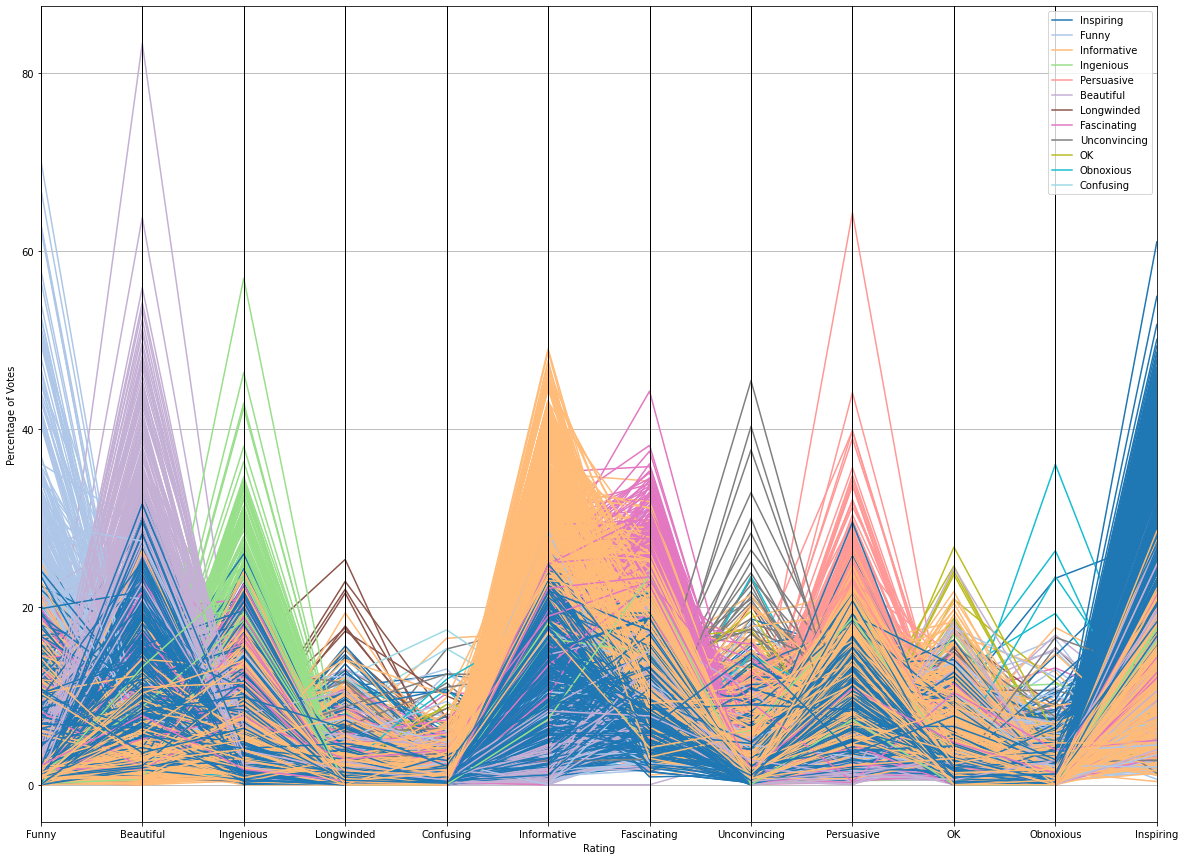

In [73]:
rating_values_updated  = percent_rating.select('Funny','Beautiful','Ingenious','Longwinded','Confusing','Informative','Fascinating','Unconvincing','Persuasive','OK','Obnoxious','Inspiring')
rating_values_updated = rating_values_updated.toPandas()
rating_values_updated['main_rating'] = rating_values_updated.idxmax(axis=1)
plt.figure(figsize=(20,15))
parallel_coordinates(rating_values_updated, 'main_rating', colormap=plt.get_cmap("tab20"))
plt.xlabel("Rating")
plt.ylabel("Percentage of Votes")

The next plot shows the number of talks that received at least one vote for each rating.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

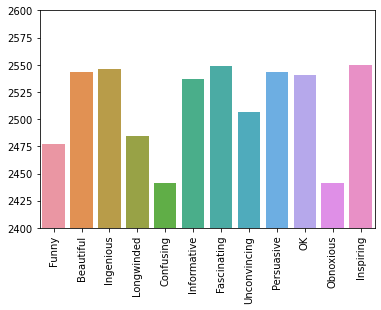

In [74]:
from collections import defaultdict
count_talks = defaultdict(list)
for rating in only_rating.columns:
    if rating in rating_parameters:
        count_talks['rating'].append(rating) 
        count_talks['count'].append(only_rating.filter(col(rating)>0).count())
sns.barplot(x="rating", y="count", data=count_talks)
plt.ylim(2400, 2600)
plt.xticks(rotation='vertical')

### Total Number of Ratings  Vs Number of Views and Total Number of Ratings Vs Number of Comments 

In [75]:
rating_views = pyspark_ted_talks.select('comments','views','total_rating').toPandas()

Correlation between views and total ratings : 0.8655856321907477


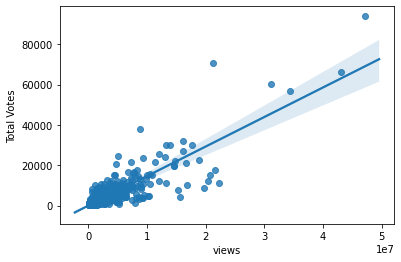

In [76]:
sns.regplot(x="views", y="total_rating", data=rating_views)
plt.xlabel("views")
plt.ylabel("Total Votes")
print("Correlation between views and total ratings : "+ str(pyspark_ted_talks.corr('views','total_rating')))

Correlation between views and total ratings : 0.6443287765879868


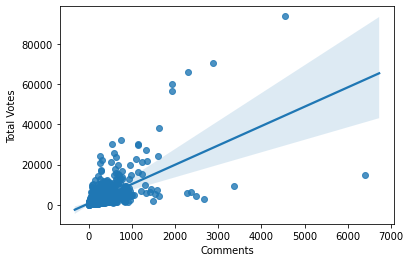

In [77]:
sns.regplot(x="comments", y="total_rating", data=rating_views)
plt.xlabel("Comments")
plt.ylabel("Total Votes")
print("Correlation between views and total ratings : "+ str(pyspark_ted_talks.corr('comments','total_rating')))

# -------------

# The transcripts data for text based content recommender

In [78]:
print(ted_scripts_pandas.shape)
ted_scripts_pandas.head()

(2467, 2)


,transcript,url
0,Good morning. How are you?(Laughter)It's been ...,https://www.ted.com/talks/ken_robinson_says_sc...
1,"Thank you so much, Chris. And it's truly a gre...",https://www.ted.com/talks/al_gore_on_averting_...
2,"(Music: ""The Sound of Silence,"" Simon & Garfun...",https://www.ted.com/talks/david_pogue_says_sim...
3,If you're here today — and I'm very happy that...,https://www.ted.com/talks/majora_carter_s_tale...
4,"About 10 years ago, I took on the task to teac...",https://www.ted.com/talks/hans_rosling_shows_t...


Insert Title column in data on the basis of URL present.

In [79]:
ted_scripts_pandas['title']=ted_scripts_pandas['url'].map(lambda x:x.split("/")[-1].replace("\n",""))

In [80]:
print(ted_scripts_pandas.shape)
ted_scripts_pandas.head()

(2467, 3)


,transcript,url,title
0,Good morning. How are you?(Laughter)It's been ...,https://www.ted.com/talks/ken_robinson_says_sc...,ken_robinson_says_schools_kill_creativity
1,"Thank you so much, Chris. And it's truly a gre...",https://www.ted.com/talks/al_gore_on_averting_...,al_gore_on_averting_climate_crisis
2,"(Music: ""The Sound of Silence,"" Simon & Garfun...",https://www.ted.com/talks/david_pogue_says_sim...,david_pogue_says_simplicity_sells
3,If you're here today — and I'm very happy that...,https://www.ted.com/talks/majora_carter_s_tale...,majora_carter_s_tale_of_urban_renewal
4,"About 10 years ago, I took on the task to teac...",https://www.ted.com/talks/hans_rosling_shows_t...,hans_rosling_shows_the_best_stats_you_ve_ever_...


Get a list of all the transcripts present in the transcipts.csv

In [81]:
transcripts_list = ted_scripts_pandas['transcript'].tolist()

# Feature Extraction on Data

Convert a collection of raw documents to a matrix of TF-IDF features.

In [82]:
term_frequency_document = text.TfidfVectorizer(input=transcripts_list,stop_words="english")

In [83]:
#term_frequency_document

Tfidf Vectorizer is a scoring measure widely used in information retrieval. TF-IDF is intended to show the importance of a term in a given document.

It gives a statistical measure used to evaluate how important a word is to a article in a collection of all transcripts. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the collection of all transcripts.

Now, we will learn the vocabulary and idf,and later return term-document matrix. This is equivalent to fit followed by transform

In [84]:
tfidf_matrix = term_frequency_document.fit_transform(transcripts_list)

Let's compute cosine similarity samples of tfidf_matrix.

In [85]:
# Get Similarity Scores using cosine similarity
similarity_scores = cosine_similarity(tfidf_matrix)

In [86]:
similarity_scores[0]

array([1.        , 0.15310631, 0.17626477, ..., 0.07427816, 0.1408498 ,
       0.06360819])

We will make a function will take the array of cosine scores as input and gives the output as similar talks. It first takes the cosine score for that particular talk, then returns the indices that would sort the cosine scores. We select only top 4 four highest scores because we only want top 5 talks and then insert the titles of those talks into the similar talks column.

# Similar Talks

In [87]:
def get_similar(sc):
    return ",".join(ted_scripts_pandas['title'].loc[sc.argsort()[-6:-1]])

Let' add column for similar articles

In [88]:
ted_scripts_pandas['similar_talks'] = [get_similar(score) for score in similarity_scores]

In [89]:
print(ted_scripts_pandas.shape)
ted_scripts_pandas.head()

(2467, 4)


,transcript,url,title,similar_talks
0,Good morning. How are you?(Laughter)It's been ...,https://www.ted.com/talks/ken_robinson_says_sc...,ken_robinson_says_schools_kill_creativity,ricardo_semler_how_to_run_a_company_with_almos...
1,"Thank you so much, Chris. And it's truly a gre...",https://www.ted.com/talks/al_gore_on_averting_...,al_gore_on_averting_climate_crisis,"david_carson_on_design,rory_bremner_s_one_man_..."
2,"(Music: ""The Sound of Silence,"" Simon & Garfun...",https://www.ted.com/talks/david_pogue_says_sim...,david_pogue_says_simplicity_sells,"john_maeda_on_the_simple_life,rory_bremner_s_o..."
3,If you're here today — and I'm very happy that...,https://www.ted.com/talks/majora_carter_s_tale...,majora_carter_s_tale_of_urban_renewal,janette_sadik_khan_new_york_s_streets_not_so_m...
4,"About 10 years ago, I took on the task to teac...",https://www.ted.com/talks/hans_rosling_shows_t...,hans_rosling_shows_the_best_stats_you_ve_ever_...,"hans_rosling_on_global_population_growth,hans_..."


Let's make a function for returning the similar talks when a topic is given.
This function will take topic as input and give output the list of recommendations (i.e. similar talks) of that particular row.

In [90]:
def recommender(topic):
    topic_data = ted_scripts_pandas.loc[ted_scripts_pandas['title'] == topic,['similar_talks']]
    recommended_data = topic_data.iloc[0]['similar_talks'].replace("_"," ").strip().split("\n")
    return recommended_data

# Output of Recommender

In [91]:
# Enter the topic name for which you want recommendation
topic_name = 'david_pogue_says_simplicity_sells'
print("The Recommendations for {} are:".format(topic_name))
print(recommender(topic_name))

The Recommendations for david_pogue_says_simplicity_sells are:
['john maeda on the simple life,rory bremner s one man world summit,david carson on design,david pogue on cool phone tricks,ze frank s nerdcore comedy']


# ----------

# Let's build a model to predict whether a TED talk will be popular or not.

# Read the data

In [92]:
# ted = pd.read_csv("C:/SDSU/BDA/Project/ted-talks/ted_main.csv")
# transcripts = pd.read_csv('C:/SDSU/BDA/Project/ted-talks/transcripts.csv')
print (ted_talks_pandas.shape, ted_scripts_pandas.shape)

(2550, 17) (2467, 4)


In [93]:
#ted.head()

Among these 2550 talks, there are some talks which are not either TED and TEDx events (for example, there is a video filmed in 1972, even before TED is established).

We need to remove those entries from the data.


### Categorize data into Ted and TedX

In [94]:
# ted = ted[ted['event'].str[0:3]=='TED'].reset_index()
ted_talks_pandas = ted_talks_pandas[ted_talks_pandas['event'].str[0:3]=='TED'].reset_index()

In [95]:
# ted.loc[:,'event_type'] = ted['event'].apply(lambda x: 'TEDx' if x[0:4]=='TEDx' else 'TED')
ted_talks_pandas.loc[:,'event_type'] = ted_talks_pandas['event'].apply(lambda x: 'TEDx' if x[0:4]=='TEDx' else 'TED')

In [96]:
print(ted_talks_pandas.shape)
ted_talks_pandas.head(3)

(2439, 19)


,index,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views,event_type
0,0,4553,Sir Ken Robinson makes an entertaining and pro...,19.400000,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110,TED
1,1,265,With the same humor and humanity he exuded in ...,16.283333,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520,TED
2,2,124,New York Times columnist David Pogue takes aim...,21.433333,TED2006,1140739200,26,David Pogue,David Pogue: Simplicity sells,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","[{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...",Technology columnist,"['computers', 'entertainment', 'interface desi...",Simplicity sells,https://www.ted.com/talks/david_pogue_says_sim...,1636292,TED


Observations:- We included a column of event_type which states whether event is Ted or TedX

Here, we change the Unix timstamp to human readable date format. Then we extract month and day of week from film date and published date.

# Prediction on basis of Ratings

There are total 14 types of possible ratings in the ted data which were given by ted useres itself. Now, we categorize them into positive, negative and neutral:
-  Positive:  'Inspiring','Jaw-dropping', 'Fascinating', 'Informative', 'Courageous', 'Ingenious',  'Persuasive','Beautiful','Funny'
-  Negative: 'Longwinded','Unconvincing', 'Confusing',  'Obnoxious'
- Neutral: 'OK'

On the basis of these ratings, we define a TED talk as 'Popular' if the count of positive ratings is greater tha. negative ratings. We calculate Popularity ratio as positive ratings to negative ratings and if it is greater than 5 the show is Popular or else it is Not Popular

In [97]:
ted_talks_pandas['ratings']=ted_talks_pandas['ratings'].str.replace("'",'"')

In [98]:
ted_talks_pandas = ted_talks_pandas.merge(ted_talks_pandas.ratings.apply(lambda x: pd.Series(pd.read_json(x)['count'].values,index=pd.read_json(x)['name'])), 
            left_index=True, right_index=True)

Let's categorize these ratings into positive and negative types

In [99]:
Positive = ['Beautiful', 'Courageous', 'Fascinating', 'Funny', 'Informative', 'Ingenious', 'Inspiring', 'Jaw-dropping', 'Persuasive']
Negative = ['Confusing', 'Longwinded', 'Obnoxious', 'Unconvincing']

In [100]:
ted_talks_pandas['positive']=ted_talks_pandas.loc[:,Positive].sum(axis=1)+1
ted_talks_pandas['negative']=ted_talks_pandas.loc[:,Negative].sum(axis=1)+1

In [101]:
ted_talks_pandas['popularity_ratio'] = ted_talks_pandas['positive']/ted_talks_pandas['negative']
ted_talks_pandas.loc[:,'Popular'] = ted_talks_pandas['popularity_ratio'].apply (lambda x: 1 if x >5 else 0)

In [102]:
print ("No. of Not Popular talks: ", len(ted_talks_pandas[ted_talks_pandas['Popular']==0]))

No. of Not Popular talks:  301


In [103]:
overall_mean_popular = np.mean(ted_talks_pandas.Popular)
print ("Ratio of Popular talks: {:.4f}".format(overall_mean_popular))

Ratio of Popular talks: 0.8766


In [104]:
print(ted_talks_pandas.shape)
ted_talks_pandas.head(3)

(2439, 37)


,index,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,...,Unconvincing,Persuasive,Jaw-dropping,OK,Obnoxious,Inspiring,positive,negative,popularity_ratio,Popular
0,0,4553,Sir Ken Robinson makes an entertaining and pro...,19.400000,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,...,300,10704,4439,1174,209,24924,91539,1139,80.367867,1
1,1,265,With the same humor and humanity he exuded in ...,16.283333,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,...,258,268,116,203,131,413,2170,565,3.840708,0
2,2,124,New York Times columnist David Pogue takes aim...,21.433333,TED2006,1140739200,26,David Pogue,David Pogue: Simplicity sells,1,...,104,230,54,146,142,230,2328,352,6.613636,1


In [105]:
#ted["Funny"]

We then use count vectorizer on tags. We will be selecting tags with occurences more than 20 only.

In [106]:
count_vector = CountVectorizer(stop_words='english',min_df=20/len(ted_talks_pandas))
tags_array = count_vector.fit_transform(ted_talks_pandas.tags).toarray()
tags_matrix = pd.DataFrame(tags_array, columns = count_vector.get_feature_names())
tags_matrix = pd.concat([tags_matrix, ted_talks_pandas.Popular], axis=1)

Here count Vectorizer converts a collection of text documents to a matrix of word counts. Then we find an array of term document matrix which is transformed from vocabulary dictionary.

Finally we concat the "Popular" column to this tags matrix. Now we have count of each tags for every talk present in the data along with the popularity column

Then we do count vectorizer on 'speaker_occupation'.

In [107]:
# Data Cleaning
ted_talks_pandas.loc[:,'occ'] = ted_talks_pandas.speaker_occupation.copy()
ted_talks_pandas.occ = ted_talks_pandas.occ.fillna('Unknown')
ted_talks_pandas.occ = ted_talks_pandas.occ.str.replace('singer/songwriter', 'singer, songwriter')
ted_talks_pandas.occ = ted_talks_pandas.occ.str.replace('singer-songwriter', 'singer, songwriter')

In [108]:
count_vector2 = CountVectorizer(stop_words='english', min_df=20/len(ted_talks_pandas))
occupation_array = count_vector2.fit_transform(ted_talks_pandas.occ).toarray()
occupation_matrix = pd.DataFrame(occupation_array, columns = count_vector2.get_feature_names())
occupation_matrix = pd.concat([occupation_matrix, ted_talks_pandas.Popular], axis=1)

Here count Vectorizer converts a collection of text documents to a matrix of word counts. Then we find an array of term document matrix which is transformed from vocabulary dictionary.

Finally we concat the "Popular" column to this occupation matrix. Now we have count of each occupation for every talk present in the data along with the popularity column

# Building a Prediction Model

We will build a prediction model to predict which talks are popular.

In [109]:
print(ted_talks_pandas.shape)
ted_talks_pandas.head()

(2439, 38)


,index,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,...,Persuasive,Jaw-dropping,OK,Obnoxious,Inspiring,positive,negative,popularity_ratio,Popular,occ
0,0,4553,Sir Ken Robinson makes an entertaining and pro...,19.400000,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,...,10704,4439,1174,209,24924,91539,1139,80.367867,1,Author/educator
1,1,265,With the same humor and humanity he exuded in ...,16.283333,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,...,268,116,203,131,413,2170,565,3.840708,0,Climate advocate
2,2,124,New York Times columnist David Pogue takes aim...,21.433333,TED2006,1140739200,26,David Pogue,David Pogue: Simplicity sells,1,...,230,54,146,142,230,2328,352,6.613636,1,Technology columnist
3,3,200,"In an emotionally charged talk, MacArthur-winn...",18.600000,TED2006,1140912000,35,Majora Carter,Majora Carter: Greening the ghetto,1,...,460,230,85,35,1070,3488,157,22.216561,1,Activist for environmental justice
4,4,593,You've never seen data presented like this. Wi...,19.833333,TED2006,1140566400,48,Hans Rosling,Hans Rosling: The best stats you've ever seen,1,...,2542,3736,248,61,2893,25063,311,80.588424,1,Global health expert; data visionary


### Splitting the data into training and testing parts

In [110]:
output = ted_talks_pandas.Popular
input_data = pd.concat([occupation_matrix.drop('Popular', axis=1), tags_matrix.drop('Popular', axis=1)], axis=1)

In [111]:
input_data_train, input_data_test, output_train, output_test = train_test_split(input_data, output, test_size=0.25, random_state=36)

The data is being split into training and testing both for input and output

### Classifier for model

Let's use different classifiers for classifying our data into Popular or Not Popular show.

#### Naive Bayes Classifier

In [112]:
nb_clf = MultinomialNB()

In [113]:
nb_clf.fit(input_data_train, output_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [114]:
output_predicton = nb_clf.predict(input_data_test)

In [115]:
print(classification_report(output_test, output_predicton))

              precision    recall  f1-score   support

           0       0.20      0.13      0.16        75
           1       0.88      0.92      0.90       535

    accuracy                           0.83       610
   macro avg       0.54      0.53      0.53       610
weighted avg       0.80      0.83      0.81       610



In [116]:
# Accuracy classification score
accuracy_score(output_test, output_predicton)

0.8262295081967214

#### KNN Classifier

In [117]:
knn_clf = KNeighborsClassifier()

In [118]:
knn_clf.fit(input_data_train, output_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [119]:
output_predicton = knn_clf.predict(input_data_test)

In [120]:
print(classification_report(output_test, output_predicton))

              precision    recall  f1-score   support

           0       0.21      0.07      0.10        75
           1       0.88      0.96      0.92       535

    accuracy                           0.85       610
   macro avg       0.54      0.52      0.51       610
weighted avg       0.80      0.85      0.82       610



In [121]:
# Accuracy classification score
accuracy_score(output_test, output_predicton)

0.8540983606557377

#### Neural Network Classifier


In [122]:
nn_clf = MLPClassifier()

In [123]:
nn_clf.fit(input_data_train, output_train)

C:\Users\nadee\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [124]:
output_predicton = nn_clf.predict(input_data_test)

In [125]:
print(classification_report(output_test, output_predicton))

              precision    recall  f1-score   support

           0       0.24      0.12      0.16        75
           1       0.88      0.95      0.92       535

    accuracy                           0.85       610
   macro avg       0.56      0.53      0.54       610
weighted avg       0.81      0.85      0.82       610



In [126]:
# Accuracy classification score.
accuracy_score(output_test, output_predicton)

0.8459016393442623

#### Random Forest Classifier

In [127]:
rfc_clf = RandomForestClassifier(n_estimators=14,max_features='auto',min_samples_split=4,random_state=0)

In [128]:
rfc_clf.fit(input_data_train, output_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=14,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

#### Output

Let's try our learned classifier on the new data i.e. input_data_test

In [129]:
output_predicton = rfc_clf.predict(input_data_test)

In [130]:
print(classification_report(output_test, output_predicton))

              precision    recall  f1-score   support

           0       0.43      0.04      0.07        75
           1       0.88      0.99      0.93       535

    accuracy                           0.88       610
   macro avg       0.65      0.52      0.50       610
weighted avg       0.83      0.88      0.83       610



In [131]:
# Accuracy classification score.
accuracy_score(output_test, output_predicton)

0.8754098360655738

Observation:<br>
Accuracies of all models:
- Naive-Bayes = 0.826
- KNN = 0.854
- Neural Network = 0.839
- Random Forest = 0.875

We can say that accuracy for Random Forest is highest and thus it is a good classifier.

In [132]:
### Testing

In [133]:
confusion_matrix(output_test, output_predicton)

array([[  3,  72],
       [  4, 531]], dtype=int64)

In [134]:
precision_score(output_test, output_predicton)

0.8805970149253731

In [135]:
recall_score(output_test, output_predicton)

0.9925233644859813

In [136]:
f1_score(output_test, output_predicton)

0.9332161687170475

#### Evaluation metrices used - 

Evaluation metrices used is Precision, Recall and F1-score
The greater the F1 Score, the better is the performance of our model. It basically tries to find the balance between precision and recall.

Here, precision provides number of correct positive results divided by the number of positive results predicted by our classifier. Whereas, Recall provides number of correct positive results divided by the number of all relevant samples.

At last, F1 Score is the Harmonic Mean between precision and recall. The range for F1 Score is [0,1]. It tells us how precise our classifier is i.e. how many instances it classifies correctly.



In [137]:
joblib.dump(rfc_clf, 'model_RandomForest.pkl')
print("Random Forest Model dumped!")

# Load the model that is just saved
rfc_clf = joblib.load('model_RandomForest.pkl')

Random Forest Model dumped!


dump statement generally persist an arbitrary python object into one file.

It basically saves our classifier into pickle format

### Checking for best depth of random forest

In [138]:
max_ = 0
for i in range(1,20):
    rfc_clf_depth = RandomForestClassifier(max_depth=i, random_state=22 , n_estimators=14)
    rfc_clf_depth.fit(input_data_train, output_train)
    output_pred = rfc_clf_depth.predict(input_data_test)
    acc = accuracy_score(output_test, output_pred)
    if(acc > max_):
        max_ = acc
        print(max_,"DEPTH =", i) 

0.8770491803278688 DEPTH = 1
0.8786885245901639 DEPTH = 11


In [139]:
rfc_clf_dept = RandomForestClassifier(max_depth=11,random_state=22 , n_estimators=14)
rfc_clf_dept.fit(input_data_train, output_train)
output_pred = rfc_clf_dept.predict(input_data_test)

#### Output

In [140]:
print(classification_report(output_test, output_pred))

              precision    recall  f1-score   support

           0       1.00      0.01      0.03        75
           1       0.88      1.00      0.94       535

    accuracy                           0.88       610
   macro avg       0.94      0.51      0.48       610
weighted avg       0.89      0.88      0.82       610



In [141]:
# Accuracy classification score.
accuracy_score(output_test, output_pred)

0.8786885245901639

### Would dimensionality reduction help get a better accuracy for the model?

We will check whether we get better accuracy by applying Principle Componenet Analysis (PCA).

In [142]:
pca = PCA(n_components=10) # Selecting 10 components
pca.fit(input_data_train)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [143]:
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.06258986 0.05176034 0.04024318 0.03455865 0.0338547  0.02398066
 0.02271291 0.0207272  0.01931031 0.01874773]
[31.32397051 28.48546959 25.11718315 23.27572226 23.03744473 19.3889973
 18.869536   18.02582571 17.39880571 17.14348882]


In [144]:
pca = PCA(n_components=7) # Selecting 7 components
pca.fit(input_data_train)

PCA(copy=True, iterated_power='auto', n_components=7, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [145]:
input_data_decom = pca.fit_transform(input_data_train, y=None)

In [146]:
rf_clf_decom = RandomForestClassifier(max_depth=11,random_state=22 , n_estimators=14)
rf_clf_decom.fit(input_data_decom, output_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=11, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=14,
                       n_jobs=None, oob_score=False, random_state=22, verbose=0,
                       warm_start=False)

In [147]:
input_data_decom_test = pca.fit_transform(input_data_test,y=None)
output_pred = rf_clf_decom.predict(input_data_decom_test)

#### Output

In [148]:
print(classification_report(output_test, output_pred))

              precision    recall  f1-score   support

           0       0.06      0.01      0.02        75
           1       0.88      0.97      0.92       535

    accuracy                           0.85       610
   macro avg       0.47      0.49      0.47       610
weighted avg       0.77      0.85      0.81       610



In [149]:
# Accuracy classification score.
accuracy_score(output_test, output_pred)

0.8524590163934426

Accuracy of model after the dimension reduction depends of the strucure of the data and how many dimensions we are going to reduce.

Above, I have tried dimesionality reduction using PCA anaysis upto 7 and 10 components.

For this data, I think that data reduction does not cause a major change in the accuracy of the model but cahnge the value to little extent. According to performance metrices full data gives better accuracy, this is because quantity of result = 1 is more than result = 0, thus changes the variance in the data too.

Overall, Accuracy provided by Random Froest Classifier is very good as compared to other classifiers.